# Exploring the differences in frequency of multiscale extreme precipitation events using GPM

In [131]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.plotting import *
from src.configs import *
from src.regions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
region = wmp_region()
pf_database = load_pf_pc(region.name)
region.get_slices()

{'lat': slice(-10, 10, None), 'lon': slice(105, 178, None)}

In [146]:
R = np.sqrt(pf_database.pc1**2 + pf_database.pc2**2)
theta = np.arctan2(pf_database.pc2, pf_database.pc1)

Text(0.5, 1.0, 'CIO')

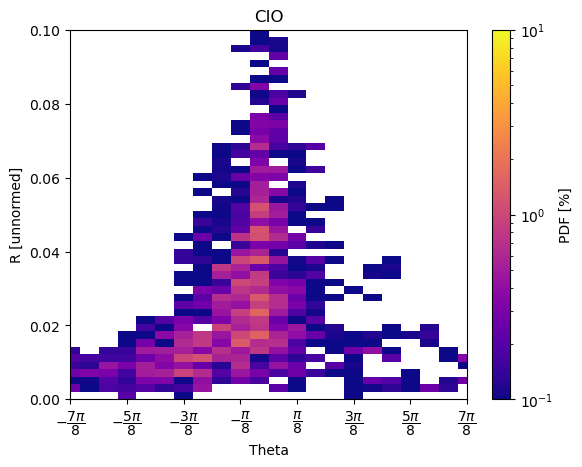

In [147]:
fig, ax = plt.subplots()
R_bins = np.linspace(0,0.1, 50)
theta_bins = np.linspace(-np.pi, np.pi, 25)
hist = binned_statistic_2d(R, theta, None, bins=[R_bins, theta_bins], statistic='count').statistic
hist = (hist/hist.sum())*100 # convert to PDF in percent
R_midpoints = (R_bins[1:] + R_bins[:-1])/2
theta_midpoints = (theta_bins[1:] + theta_bins[:-1])/2

x_mesh, y_mesh = np.meshgrid(theta_midpoints, R_midpoints)
cmap = plt.cm.plasma
norm = colors.LogNorm(vmin=1e-1, vmax=1e1)
c = ax.pcolormesh(x_mesh, y_mesh, hist, norm=norm, cmap=cmap)
cb = fig.colorbar(c)
cb.ax.set_ylabel('PDF [%]')
ax.set_xlabel('Theta')
ax.set_ylabel('R [unnormed]')
ax = label_xaxis_theta(ax)
ax.set_title(region.name)

Now we examine how the distribution looks for extreme events

In [163]:
pr = (pf_database.total_precip/pf_database.num_pixels)
pr_thresh = pr.quantile(0.90)
epe_id = (pr >= pr_thresh)
print(f'Extreme Precip threshold set at {pr_thresh:0.2f} mm/hr')

Extreme Precip threshold set at 4.33 mm/hr


6076.0


Text(0.5, 1.0, 'WMP PDF of Extreme Events')

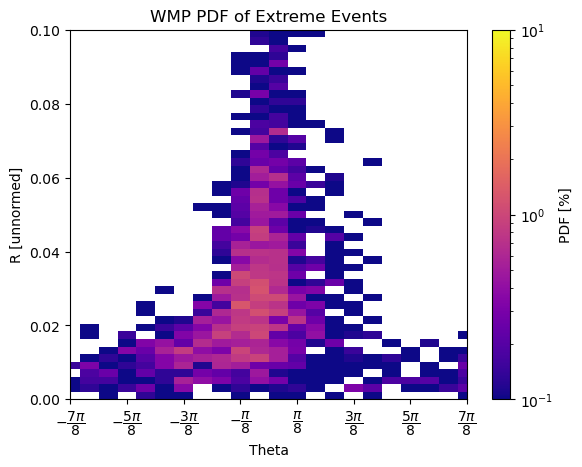

In [164]:
epe_pfs = pf_database.where(epe_id).dropna()
R = np.sqrt(epe_pfs.pc1**2 + epe_pfs.pc2**2)
theta = np.arctan2(epe_pfs.pc2, epe_pfs.pc1)
fig, ax = plt.subplots()

R_bins = np.linspace(0,0.1, 50)
theta_bins = np.linspace(-np.pi, np.pi, 25)
hist = binned_statistic_2d(R, theta, None, bins=[R_bins, theta_bins], statistic='count').statistic
print(hist.sum())
hist = (hist/hist.sum())*100 # convert to PDF in percent
R_midpoints = (R_bins[1:] + R_bins[:-1])/2
theta_midpoints = (theta_bins[1:] + theta_bins[:-1])/2

x_mesh, y_mesh = np.meshgrid(theta_midpoints, R_midpoints)
cmap = plt.cm.plasma
norm = colors.LogNorm(vmin=1e-1, vmax=1e1)
c = ax.pcolormesh(x_mesh, y_mesh, hist, norm=norm, cmap=cmap)
cb = fig.colorbar(c)
cb.ax.set_ylabel('PDF [%]')
ax.set_xlabel('Theta')
ax.set_ylabel('R [unnormed]')
ax = label_xaxis_theta(ax)
ax.set_title(f'{region.name} PDF of Extreme Events')

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_82662/772096744.py:22: RuntimeWarning: invalid value encountered in divide
  prob = (hist/num_epes) * 100
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_82662/772096744.py:22: RuntimeWarning: invalid value encountered in divide
  prob = (hist/num_epes) * 100
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_82662/772096744.py:22: RuntimeWarning: invalid value encountered in divide
  prob = (hist/num_epes) * 100
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_82662/772096744.py:22: RuntimeWarning: invalid value encountered in divide
  prob = (hist/num_epes) * 100


Text(0.5, 0.98, 'WMP')

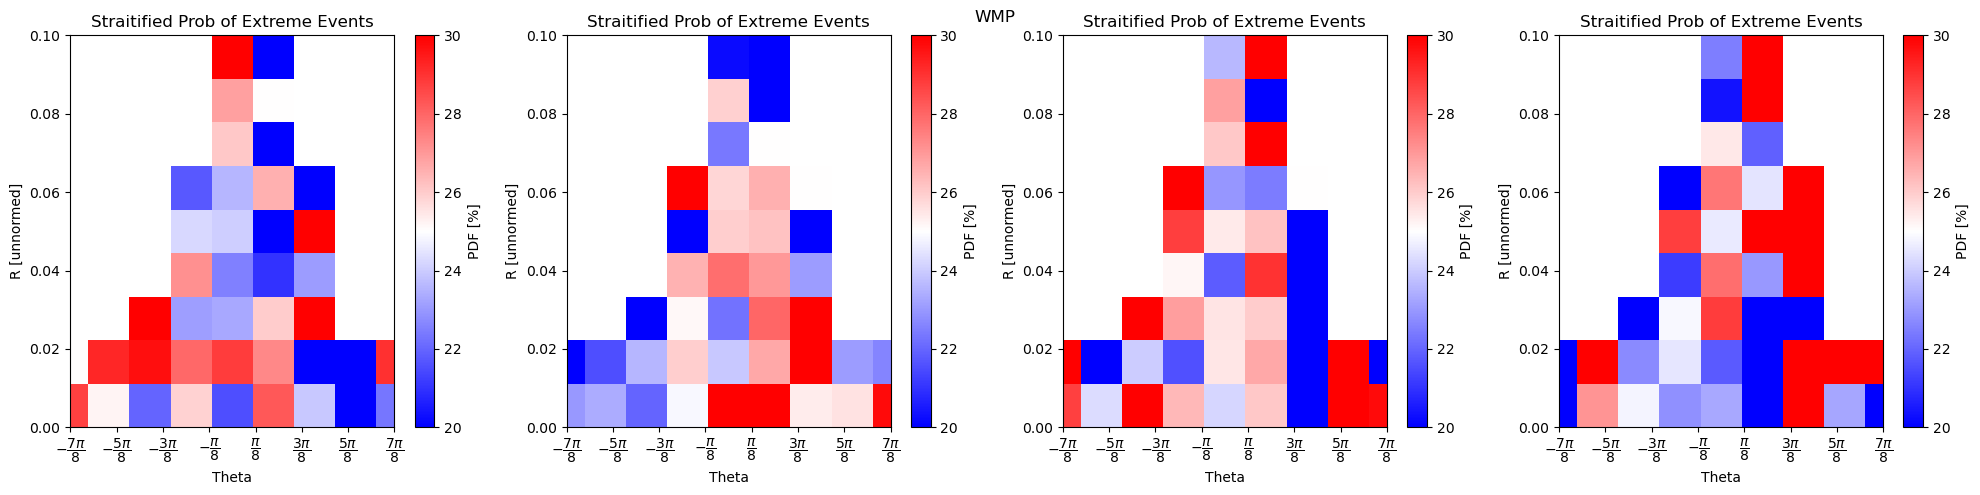

In [172]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
epe_pfs = pf_database.where(epe_id).dropna()
R = np.sqrt(epe_pfs.pc1**2 + epe_pfs.pc2**2)
theta = np.arctan2(epe_pfs.pc2, epe_pfs.pc1)
R_bins = np.linspace(0,0.1, 10)
theta_bins = np.linspace(-np.pi, np.pi, 10)
num_epes = binned_statistic_2d(R, theta, None, bins=[R_bins, theta_bins], statistic='count').statistic

# choose metric to stratify by 
org = epe_pfs.total_precip
epe_pfs['org'] = org
for i, ax in enumerate(axs.ravel()):

    # how we look 
    quad_id = (org.quantile(i*0.25)<org) & (org<=org.quantile((i+1)*0.25))
    quad_df = epe_pfs.where(quad_id).dropna()

    quad_R = np.sqrt(quad_df.pc1**2 + quad_df.pc2**2)
    quad_theta = np.arctan2(quad_df.pc2, quad_df.pc1)
    quad_org = quad_df.org
    hist = binned_statistic_2d(quad_R, quad_theta, None, bins=[R_bins, theta_bins], statistic='count').statistic
    prob = (hist/num_epes) * 100
    R_midpoints = (R_bins[1:] + R_bins[:-1])/2
    theta_midpoints = (theta_bins[1:] + theta_bins[:-1])/2

    x_mesh, y_mesh = np.meshgrid(theta_midpoints, R_midpoints)
    cmap = plt.cm.bwr
    norm = colors.TwoSlopeNorm(vmin=20, vcenter=25, vmax=30)
    c = ax.pcolormesh(x_mesh, y_mesh, prob, norm=norm, cmap=cmap)
    cb = fig.colorbar(c)
    cb.ax.set_ylabel('PDF [%]')
    ax.set_xlabel('Theta')
    ax.set_ylabel('R [unnormed]')
    ax = label_xaxis_theta(ax)
    ax.set_title('Straitified Prob of Extreme Events')
fig.tight_layout()
fig.suptitle(region.name)